In [1]:
import pandas as pd
import os
import re
import json
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIRECTORY = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')
MIGRATION_FOLDER = "productDownload_2021-09-15T103433"

## Working with County-to-County Migration Flows Data

These steps will take the county to county migration XLSX file sheets and output the migration CSV files for each individual U.S. state + Puerto Rico + D.C. Each file needs its header and footer to be managed correctly when reading with pandas, but in between the header and footer areas is a standard, well formatted table.

(1) Download "In-, Out-, Net, and Gross Migration" file from Latest [Census Count-to-County Migration Flows](https://www.census.gov/topics/population/migration/guidance/county-to-county-migration-flows.html)

(2) Place file in `data-puerto-rico-migration/data` folder

(3) Run `bash xlsx_to_csv.sh` from the `data-puerto-rico-migration/data` folder

In [2]:
c2c_filenames = []
for file in os.listdir(DATA_DIRECTORY):
    if file.startswith("county-to-county-2015-2019-ins-outs-nets-gross-"):
        c2c_filenames.append(file)

In [3]:
def format_county_flow_df(filename):
    county_flow_df = pd.read_csv(os.path.join(DATA_DIRECTORY, filename), skiprows=1, skipfooter=6, engine="python")
    
    colnames = []
    for i, colname in enumerate(county_flow_df.columns):
        if "Unnamed" in colname:
            colnames.append(colnames[i-1] + ' (' + county_flow_df.iloc[0, i] + ')')
        else:
            colnames.append(colname)

    county_flow_df.rename(columns=dict(zip(county_flow_df.columns, colnames)), inplace=True)
    county_flow_df = county_flow_df.drop(county_flow_df.index[[0]])
    return county_flow_df

In [4]:
c2c_dfs = [format_county_flow_df(filename) for filename in c2c_filenames]

In [5]:
c2c_df = pd.concat(c2c_dfs)

In [6]:
c2c_df

,State Code of Geography A,FIPS County Code of Geography A,State/U.S. Island Area/Foreign Region Code of Geography B,FIPS County Code of Geography B,State Name of Geography A,County Name of Geography A,State/U.S. Island Area/Foreign Region of Geography B,County Name of Geography B,Flow from Geography B to Geography A,Flow from Geography B to Geography A (MOE),Counterflow from Geography A to Geography B1,Counterflow from Geography A to Geography B1 (MOE),Net Migration from Geography B to Geography A1,Net Migration from Geography B to Geography A1 (MOE),Gross Migration between Geography A and Geography B1,Gross Migration between Geography A and Geography B1 (MOE)
1,15.0,1.0,001,15.0,Hawaii,Hawaii County,Alabama,Calhoun County,21,34,0,28,21,34,21,34
2,15.0,1.0,001,45.0,Hawaii,Hawaii County,Alabama,Dale County,0,27,11,20,-11,20,11,20
3,15.0,1.0,001,75.0,Hawaii,Hawaii County,Alabama,Lamar County,0,27,5,8,-5,8,5,8
4,15.0,1.0,002,20.0,Hawaii,Hawaii County,Alaska,Anchorage Municipality,32,46,90,102,-58,108,122,116
5,15.0,1.0,002,90.0,Hawaii,Hawaii County,Alaska,Fairbanks North Star Borough,4,6,0,22,4,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13352,26.0,165.0,055,25.0,Michigan,Wexford County,Wisconsin,Dane County,24,37,0,20,24,37,24,37
13353,26.0,165.0,055,73.0,Michigan,Wexford County,Wisconsin,Marathon County,0,22,6,7,-6,7,6,7
13354,26.0,165.0,ASI,NaN,Michigan,Wexford County,Asia,-,14,19,NaN,NaN,NaN,NaN,NaN,NaN
13355,26.0,165.0,CAM,NaN,Michigan,Wexford County,Central America,-,4,6,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def get_inflows_into_place(county_to_county_df, place, place_type="state"):
    column_name_a = "State Name of Geography A" if place_type == "state" else "County Name of Geography A"
    column_name_b = "State/U.S. Island Area/Foreign Region of Geography B" if place_type == "state" else "County Name of Geography B"
    county_to_county_df["Flow from Geography B to Geography A"] = pd.to_numeric(county_to_county_df["Flow from Geography B to Geography A"])
    county_to_county_df['Net Migration from Geography B to Geography A1'] = pd.to_numeric(county_to_county_df['Net Migration from Geography B to Geography A1'])
    county_to_county_df['Counterflow from Geography A to Geography B1'] = pd.to_numeric(county_to_county_df['Counterflow from Geography A to Geography B1'])

    return county_to_county_df[
        (county_to_county_df[column_name_a] == place) &
        (county_to_county_df[column_name_b] != place) &
        (county_to_county_df["Flow from Geography B to Geography A"] != 0)
    ].sort_values(["Flow from Geography B to Geography A"], ascending=[False])

In [8]:
def get_outflows_from_place(county_to_county_df, place, place_type="state"):
    column_name_a = "State Name of Geography A" if place_type == "state" else "County Name of Geography A"
    column_name_b = "State/U.S. Island Area/Foreign Region of Geography B" if place_type == "state" else "County Name of Geography B"
    county_to_county_df["Flow from Geography B to Geography A"] = pd.to_numeric(county_to_county_df["Flow from Geography B to Geography A"])
    county_to_county_df['Net Migration from Geography B to Geography A1'] = pd.to_numeric(county_to_county_df['Net Migration from Geography B to Geography A1'])
    county_to_county_df['Counterflow from Geography A to Geography B1'] = pd.to_numeric(county_to_county_df['Counterflow from Geography A to Geography B1'])

    return county_to_county_df[
        (county_to_county_df[column_name_a] != place) &
        (county_to_county_df[column_name_b] == place) &
        (county_to_county_df["Flow from Geography B to Geography A"] != 0)
    ].sort_values(["Flow from Geography B to Geography A"], ascending=[False]) # ['Flow from Geography B to Geography A']).sum()

In [9]:
def get_intraflows_of_place(county_to_county_df, place, place_type="state"):
    column_name_a = "State Name of Geography A" if place_type == "state" else "County Name of Geography A"
    column_name_b = "State/U.S. Island Area/Foreign Region of Geography B" if place_type == "state" else "County Name of Geography B"
    county_to_county_df["Flow from Geography B to Geography A"] = pd.to_numeric(county_to_county_df["Flow from Geography B to Geography A"])
    county_to_county_df['Net Migration from Geography B to Geography A1'] = pd.to_numeric(county_to_county_df['Net Migration from Geography B to Geography A1'])
    county_to_county_df['Counterflow from Geography A to Geography B1'] = pd.to_numeric(county_to_county_df['Counterflow from Geography A to Geography B1'])

    return county_to_county_df[
        (county_to_county_df[column_name_a] == place) &
        (county_to_county_df[column_name_b] == place) &
        (county_to_county_df["Flow from Geography B to Geography A"] != 0)
    ].sort_values(["Flow from Geography B to Geography A"], ascending=[False])

In [10]:
place = 'Puerto Rico'
inflows = get_inflows_into_place(c2c_df, place, place_type='state')
outflows = get_outflows_from_place(c2c_df, place, place_type='state')
intraflows = get_intraflows_of_place(c2c_df, place, place_type='state')

In [11]:
county_places = set(
    c2c_df[(c2c_df["State Name of Geography A"] == place)]["County Name of Geography A"].tolist() +
    c2c_df[(c2c_df["State/U.S. Island Area/Foreign Region of Geography B"] == place)]["County Name of Geography B"].tolist()
)

In [12]:
us_state_to_abbrev = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR", "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI"}
county_fips = {}
for county_place in county_places:
    a = c2c_df[c2c_df["County Name of Geography A"] == county_place]
    if len(a) > 0:
        fips = a["FIPS County Code of Geography A"].iloc[0]
    else:
        b = c2c_df[c2c_df["County Name of Geography B"] == county_place]
        fips = b["FIPS County Code of Geography B"].iloc[0]
    county_fips[county_place] = str(int(fips))

In [13]:
county_flows = {}
for county_place in county_places:
    
    county_inflows = inflows[inflows["County Name of Geography A"] == county_place]
    county_inflows = county_inflows.fillna(0)
    
    county_flows[county_place] = {
        "state_fips": "72",
        "county_fips": county_fips[county_place],
        "total_inflow": int(county_inflows['Flow from Geography B to Geography A'].sum()),
        "total_outflow": int(county_inflows['Counterflow from Geography A to Geography B1'].sum()),
        "total_net": int(county_inflows['Net Migration from Geography B to Geography A1'].sum()),
        "flows": []
    }
    
    for i, row in county_inflows.iterrows():
        prev_county = row['County Name of Geography B'].replace('city', 'City')
        prev_county_fips = str(int(row['FIPS County Code of Geography B']))
        
        prev_state_fips = row['State/U.S. Island Area/Foreign Region Code of Geography B']
        prev_state = row['State/U.S. Island Area/Foreign Region of Geography B']
        
        if prev_state in us_state_to_abbrev:
            prev_state = us_state_to_abbrev[prev_state]
        
        inflow = int(row['Flow from Geography B to Geography A'])
        outflow = int(row['Counterflow from Geography A to Geography B1'])
        net = int(row['Net Migration from Geography B to Geography A1'])
        
        # For this analysis, remove the non-U.S. numbers
#         if prev_county != "-":
        county_flows[county_place]["flows"].append({
            "prev_county": prev_county,
            "prev_county_fips": prev_county_fips,
            "prev_state": prev_state,
            "prev_state_fips": prev_state_fips,
            "inflow": inflow,
            "outflow": outflow,
            "net": net
        })     

In [14]:
puerto_rico_summary = {
    "state_fips": "72",
    "total_inflow": int(inflows['Flow from Geography B to Geography A'].sum()),
    "total_outflow": int(inflows['Counterflow from Geography A to Geography B1'].sum()),
    "total_net": int(inflows['Net Migration from Geography B to Geography A1'].sum()),
    "flows": []
}
all_outside_pr = set(inflows['County Name of Geography B'].tolist())
all_outside_pr_inflows = [inflows[inflows['County Name of Geography B'] == outside_pr]['Flow from Geography B to Geography A'].sum() for outside_pr in all_outside_pr]
all_outside_pr_dict = dict(zip(all_outside_pr, all_outside_pr_inflows))

all_outside_pr_sorted = dict(sorted(all_outside_pr_dict.items(), key=lambda item: -item[1]))

for outside_pr in all_outside_pr_sorted.keys():
    outside_data = inflows[inflows['County Name of Geography B'] == outside_pr]
    outside_data = outside_data.fillna(0)
    
    prev_county = outside_pr.replace('city', 'City')
    prev_county_fips = str(int(outside_data['FIPS County Code of Geography B'].iloc[0]))

    prev_state_fips = outside_data['State/U.S. Island Area/Foreign Region Code of Geography B'].iloc[0]
    prev_state = outside_data['State/U.S. Island Area/Foreign Region of Geography B'].iloc[0]
    
    if prev_state in us_state_to_abbrev:
        prev_state = us_state_to_abbrev[prev_state]
            
    inflow = int(outside_data['Flow from Geography B to Geography A'].sum())
    outflow = int(outside_data['Counterflow from Geography A to Geography B1'].sum())
    net = int(outside_data['Net Migration from Geography B to Geography A1'].sum())
    
#     if prev_county != '-':
    puerto_rico_summary['flows'].append({
        "prev_county": prev_county,
        "prev_county_fips": prev_county_fips,
        "prev_state": prev_state,
        "prev_state_fips": prev_state_fips,
        "inflow": inflow,
        "outflow": outflow,
        "net": net
    })
    
county_flows["Puerto Rico"] = puerto_rico_summary

In [15]:
with open(os.path.join(DATA_DIRECTORY, 'county_flows.json'), 'w') as f:
    json.dump(county_flows, f, ensure_ascii=False)

## Working with ACS 1-Year Data

(1) Download data for years 2010- from [Census tables](https://data.census.gov/cedsci/table?q=migration&g=0400000US72&tid=ACSST1Y2010.S0701PR&hidePreview=false) (table name: GEOGRAPHIC MOBILITY BY SELECTED CHARACTERISTICS IN PUERTO RICO)

(2) Move file and unzip into `data-puerto-rico-migration/data`

In [16]:
migration_filenames = []
for file in os.listdir(os.path.join(DATA_DIRECTORY, MIGRATION_FOLDER)):
    if re.match(r'ACSST1Y20[0-9][0-9].S0701PR_data_with_overlays_', file):
        migration_filenames.append(file)

In [17]:
def format_migration_df(filename, folder=MIGRATION_FOLDER):
    migration_df = pd.read_csv(os.path.join(DATA_DIRECTORY, folder, filename))
    
    columns_to_keep = []
    for i, value in enumerate(migration_df.iloc[0,:]):
        if ('!!AGE' in value or value.endswith("Estimate!!Median age (years)")) and "Margin of Error" not in value:
            columns_to_keep.append(migration_df.columns[i])
    migration_df = migration_df[columns_to_keep]
    migration_df = migration_df.drop(migration_df.index[[0]])
    migration_df = migration_df.apply(pd.to_numeric)
    return migration_df

In [18]:
migration_dfs = [format_migration_df(filename) for filename in sorted(migration_filenames)]

In [19]:
migration_df = pd.concat(migration_dfs)

In [20]:
migration_df = migration_df.reset_index(drop=True)
migration_df

,S0701PR_C01_002E,S0701PR_C01_003E,S0701PR_C01_004E,S0701PR_C01_005E,S0701PR_C01_006E,S0701PR_C01_007E,S0701PR_C01_008E,S0701PR_C01_009E,S0701PR_C01_010E,S0701PR_C01_011E,...,S0701PR_C05_002E,S0701PR_C05_003E,S0701PR_C05_004E,S0701PR_C05_005E,S0701PR_C05_006E,S0701PR_C05_007E,S0701PR_C05_008E,S0701PR_C05_009E,S0701PR_C05_010E,S0701PR_C05_011E
0,177607,674397,379556,482756,487539,486273,442644,313604,232117,37.7,...,0.2,0.1,0.2,0.2,0.1,0.1,0.2,0.0,0.0,28.4
1,179297,659703,386680,471617,482098,483136,441592,326228,238844,37.9,...,0.3,0.1,0.2,0.2,0.2,0.1,0.1,0.0,0.0,30.4
2,170672,640007,385586,456664,476239,479067,438133,336891,245143,38.3,...,0.0,0.0,0.2,0.2,0.1,0.1,0.1,0.2,0.1,31.8
3,163481,614727,383594,439708,473876,469242,434929,345893,253770,38.9,...,0.1,0.1,0.2,0.2,0.2,0.2,0.1,0.0,0.1,38.2
4,147077,588457,374975,430490,458266,461164,433746,354429,262582,39.8,...,0.0,0.1,0.1,0.2,0.1,0.1,0.0,0.0,0.0,31.7
5,142159,564497,354263,421169,448443,455086,430863,357541,269424,40.4,...,0.1,0.2,0.1,0.3,0.2,0.1,0.1,0.0,0.1,30.7
6,133206,536123,343234,413129,440352,440533,432298,365448,280437,41.0,...,0.0,0.1,0.2,0.3,0.1,0.1,0.1,0.1,0.0,27.6
7,123041,510095,336708,396657,427844,430603,429816,368874,289881,41.7,...,0.0,0.1,0.1,0.2,0.0,0.1,0.2,0.1,0.0,32.9
8,104599,468214,313113,381445,396979,422128,426262,361819,299397,43.2,...,0.0,0.1,0.2,0.2,0.1,0.1,0.0,0.1,0.0,35.8
9,97544,457331,319225,385530,395192,412923,428425,366492,313173,43.4,...,0.2,0.1,0.2,0.6,0.3,0.1,0.1,0.1,0.0,33.3


In [21]:
moved_from_us = [
    'S0701PR_C04_002E', 
    'S0701PR_C04_003E', 
    'S0701PR_C04_004E', 
    'S0701PR_C04_005E', 
    'S0701PR_C04_006E', 
    'S0701PR_C04_007E', 
    'S0701PR_C04_008E', 
    'S0701PR_C04_009E',
    'S0701PR_C04_010E'
]

moved_from_outside_pr_and_us = [
    'S0701PR_C05_002E',
    'S0701PR_C05_003E',
    'S0701PR_C05_004E',
    'S0701PR_C05_005E',
    'S0701PR_C05_006E',
    'S0701PR_C05_007E',
    'S0701PR_C05_008E',
    'S0701PR_C05_009E',
    'S0701PR_C05_010E',
]

ages = [
    'S0701PR_C01_002E',
    'S0701PR_C01_003E',
    'S0701PR_C01_004E',
    'S0701PR_C01_005E',
    'S0701PR_C01_006E',
    'S0701PR_C01_007E',
    'S0701PR_C01_008E',
    'S0701PR_C01_009E',
    'S0701PR_C01_010E',
]

In [22]:
df1 = pd.DataFrame(
    migration_df[moved_from_us].values * migration_df[ages].values / 100,
    columns=migration_df[moved_from_us].columns,
    index=migration_df[moved_from_us].index
)

df2 = pd.DataFrame(
    migration_df[moved_from_outside_pr_and_us].values * migration_df[ages].values / 100,
    columns=migration_df[moved_from_us].columns,
    index=migration_df[moved_from_us].index
)

df3 = df1.add(df2, fill_value=0)

<Figure size 432x288 with 0 Axes>

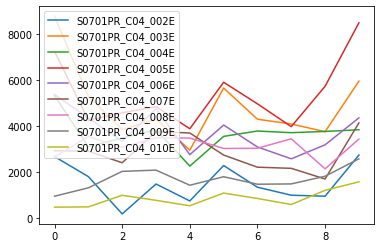

In [23]:
plt.figure();
df3.plot.line(legend=None)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

In [24]:
age_groups = [
    '0-4',
    '5-17',
    '18-24',
    '25-34',
    '35-44',
    '45-54',
    '55-64',
    '65+',
]

years = [
    '2010',
    '2011',
    '2012',    
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018',
    '2019'
]

migration_json = []
for i, age_group in enumerate(age_groups):
    time_series = [ ]
    for j, val in enumerate(df3.iloc[:,i]):
        if i == (len(age_groups) - 1):
            val += df3.iloc[j,i+1]
        time_series.append({'year': years[j], 'value': round(val)})
    
    migration_dict = {
        'ageGroup': age_group,
        'timeSeries': time_series
    }
    migration_json.append(migration_dict)

    

In [25]:
with open(os.path.join(DATA_DIRECTORY, 'acs_migration_data.json'), 'w') as f:
    json.dump(migration_json, f)